## Importing libraries we'll need

In [1]:
#importing libraries we'll need
import pandas as pd
import numpy as np
np.seterr(over='ignore') #because many parameters have zeros, this can lead to infs but doesn't affect results, so error ignored
import math
from sklearn import model_selection #this will be used to randomise the data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
%matplotlib inline

## Loading the file

In [2]:
#importing data
df = pd.read_csv(r'P:\ENGINEERING\FPO\Digitalisation\1 FPO Projects\IIX Data Analytics\02-General presentations\Knowledge folder - preparation\Data Science Learning Framework\Machine Learning Posters\4 - Neural Networks\flight_segmentation_data.csv')

df.head() #print 1st 5 rows to understand data

,msn,flight,airline_icao,model,%_into_flight,flight_segment,altitude,mach,TAS,vertical_speed,mean_cruise_alt,static_pressure,WHLSPD_1,AOA,flap_pos,COG,main_g_out,roll,cl
0,7802,5,EZY,A320,54.059406,CRUISE,37024.33333,0.781542,445.291667,-17.000000,37505.77471,212.320312,0.0,2.373047,0.0,27.451508,0,0,0.580665
1,7802,5,EZY,A320,44.356436,CRUISE,37037.33333,0.794167,453.104167,-6.333333,37505.77471,212.046875,0.0,2.197266,0.0,27.171492,0,0,0.570220
2,7802,5,EZY,A320,71.683168,CRUISE,38993.66667,0.773125,436.541667,-14.666667,37505.77471,193.257812,0.0,2.812500,0.0,28.031540,0,0,0.637519
3,7802,5,EZY,A320,78.613861,CRUISE,39031.33333,0.784958,443.000000,18.666667,37505.77471,192.796875,0.0,2.460938,0.0,28.271553,0,0,0.615025
4,7802,5,EZY,A320,81.980198,CRUISE,39051.33333,0.785208,442.729167,-74.000000,37505.77471,192.585938,0.0,2.416992,0.0,28.391560,0,0,0.612682


## Formatting the data

In [3]:
#separating into features and labels, msn, flight, airline and model aren't features or labels but will be useful for post processing
#% into flight would be increase accuracy, but we want to try to make a network that only relies on aircraft parameters
X = np.array(df.drop(["msn","flight","airline_icao","model","flight_segment","%_into_flight"],axis = 1)) #features
y = np.array(df["flight_segment"]) #labels

#splitting the data randomly into training/testing data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=101)
#performing same train test split, but X contains all columns, these are the dataframes that'll be used for post processing
X_train_all, X_test_all, y_train, y_test = model_selection.train_test_split(df, y, test_size=0.3, random_state=101)

In [4]:
#formatting the target data into the correct format for the final layer of neurons
#if there are 4 classes, will create something like [0,0,1,0] column vector
classes = list(df.drop_duplicates("flight_segment")["flight_segment"]) #classes are all the different label values, CRUISE etc...
no_of_classes = len(classes)

#for each row, will make a list of 0s, except a 1 for the target value using boolean as integer operations, then reshape into a column vector
targets_train = [np.reshape(np.array([int(y_train[i] == j) for j in classes]), (no_of_classes,1)) for i in range(len(y_train))]
targets_test = [np.reshape(np.array([int(y_test[i] == j) for j in classes]), (no_of_classes,1)) for i in range(len(y_test))]

## The Network

In [5]:
class Network(object):

    def __init__(self, sizes):
        '''setting no. of layers, sizes of layers and generating weights and activation matrices on creation of network'''
        
        self.layers = len(sizes)
        self.sizes = sizes
        #weight matrix of each layer must have as many columns as present layer activations (+1 for bias) and as many rows as the next
        self.weights = [np.random.randn(i,j+1) for i,j in zip(sizes[1:],sizes[:-1])]
        
        #activations vector of each layer must have as many entries as activations for that layer (+1 for bias), 
        #except for the last layer which only has the outputs (no bias feeding into next layer)
        #it must be set with ones instead of zeros since the biases won't be changed and must be non-zero!
        self.activations = [np.ones((i+1,1)) for i in sizes[:-1]] + [np.ones((sizes[-1],1))]
        
    def feed_fwd(self, X, tr_ex):
        '''feed forward algorithm that multiplies values through from the input to the output layer'''
        
        self.activations[0][:,0] = np.append(X[tr_ex],1) #sets initial layer as input data values, then appends 1 for bias
        for i in range(self.layers-1): #iterates through layers (forward propagation)
            #for a given layer, will set every activation entry except the bias as the outputs from the previous layer
            self.activations[i+1][:self.sizes[i+1]] = self.sigmoid(np.dot(self.weights[i],self.activations[i]))
            
        return self.activations[-1] #returns last layer of activations (network output)

    def cost_func(self, X, y, iteration):
        '''defines the cost (how wrong the algorithm is) at a given iteration'''
        self.cost[iteration] = -(float(1)/len(X))*np.sum(np.array([y[i]*np.log(nn.feed_fwd(X,i)) + (1-y[i])*np.log(1-nn.feed_fwd(X,i)) for i in range(len(X))]))
    
    def backprop(self, X, y, train_its):
        '''backpropagation algorithm, which trains the network'''
        
        alpha = 0.1 #setting the learning rate
        self.cost = np.zeros((train_its)) #list to append cost at each iteration, so we can plot and make sure decreasing
        for iteration in range(train_its): #iterating through training iterations (epochs)
            
            if float(iteration)*100/train_its % 5 == 0: #printing % complete if multiple of 5
                print("{}% complete".format(np.round(float(iteration)*100/train_its)))
            
            self.cost_func(X, y, iteration) #calulating cost function for a given iteration
            
            #setting a list of matrices for the changes to weights in each iteration
            DELTAS = [np.zeros((i,j+1)) for i,j in zip(self.sizes[1:],self.sizes[:-1])]
            
            for tr_idx, tr_ex in enumerate(X): #for each training example
                
                #setting a list of matrices to change the amount (for each training example) of change (for each training iteration) to weights
                deltas = [0 for i in range(self.layers)]
                #running feed_fwd for the networks current output of this training example (activations needed for backpropagation) 
                self.feed_fwd(X, tr_idx)
                
                for layer in range(self.layers)[::-1]: #iterating backward through layers (backpropagation)
                    
                    #if its the final layer, set the delta (how wrong activations are), as difference between output and target
                    if layer == self.layers-1:
                        delta = self.activations[layer] - y[tr_idx]
                    
                    #otherwise use equation to propagate error backward from layer before
                    else:
                        delta = np.dot(self.weights[layer].transpose(),delta[:self.sizes[layer+1]])*self.activations[layer]*(1-self.activations[layer])

                    deltas[layer] = delta #assign activation deltas for the layer to deltas list
                
                #add these deltas for this training example to the overall change for this iteration
                DELTAS = [DELTAS[i] + np.dot(deltas[i+1][:self.sizes[i+1]], self.activations[i].transpose()) for i in range(self.layers-1)]

            #subtract the overall change for this iteration from the weights, to complete iteration by creating new weight values
            self.weights = [self.weights[i] - (float(1)/len(X))*alpha*DELTAS[i] for i in range(len(self.weights))]

    def sigmoid(self, h_value):
        '''the sigmoid function, which normalises values to between 0 and 1'''
        return float(1)/(1+math.e**-h_value)

In [6]:
#defining our network, with the sizes of each layer given (first must be no. of features, last must be no. of classes)
#add many layers of any size! eg. [input, 100, 100, 100, output], investigate the effect this has on training time and results

nn = Network([X.shape[1], 60, 60, no_of_classes]) #X.shape[1] returns no. of columns in feature matrix, i.e. no of input neurons

In [7]:
training_its = 500 #setting number of training iterations
nn.backprop(X_train, targets_train, training_its) #training the network

#saving the network to the file directory, so we don't have to train it every time
with open ('NeuralNet_flight_phase.pickle','wb') as f:
    pickle.dump(nn, f)

0.0% complete
5.0% complete
10.0% complete
15.0% complete
20.0% complete
25.0% complete
30.0% complete
35.0% complete
40.0% complete
45.0% complete
50.0% complete
55.0% complete
60.0% complete
65.0% complete
70.0% complete
75.0% complete
80.0% complete
85.0% complete
90.0% complete
95.0% complete


In [ ]:
#loading a network from a previously saved file (no need to do this if you just trained it)
pickle_in = open('NeuralNet_flight_phase.pickle','rb')
nn = pickle.load(pickle_in)

## Checking the cost

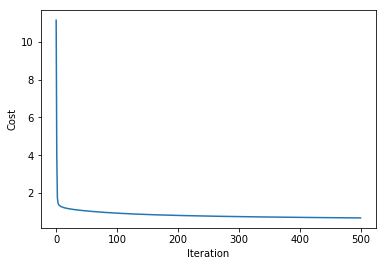

In [8]:
plt.plot(range(training_its),nn.cost) #plotting iteration vs. cost (to see how it decreases with training iterations)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## Output for an individual row

In [9]:
test_no = 193 #this number can be changed to anything between 0 and 3000 to test different examples

classes_dict = {idx : val for idx,val in enumerate(classes)} #creating a dictionary to link the output neuron index to the flight phase
#predicting digit value by putting input data through network with feed_fwd function, then indexing y_test for actual value
print("Prediction, Actual: {}, {}".format(classes_dict[np.argmax(nn.feed_fwd(X_test, test_no))], y_test[test_no]))
print()
print("Final Layer Activations:")
print(nn.feed_fwd(X_test, test_no)) #whichever output has the highest value, is the selected class

Prediction, Actual: CRUISE, CRUISE

Final Layer Activations:
[[  8.97662022e-01]
 [  2.26057045e-02]
 [  8.89747204e-02]
 [  3.80504646e-04]]


## Results

In [10]:
#calculating the number of correctly assigned values in the test data

#adding predicted values, by applying feed_fwd and taking max output
X_test_all["predicted"] = [classes_dict[np.argmax(nn.feed_fwd(X_test, iteration))] for iteration in range(len(X_test))]

correct = len(X_test_all[X_test_all["flight_segment"] == X_test_all["predicted"]]) #length of df where actual = predicted is number of correctly estimated digits
fraction = float(correct)/len(X_test_all) #divide by total digits in test data for % correct
print("{}% correctly assigned".format(np.round(fraction*100,2)))

92.52% correctly assigned


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


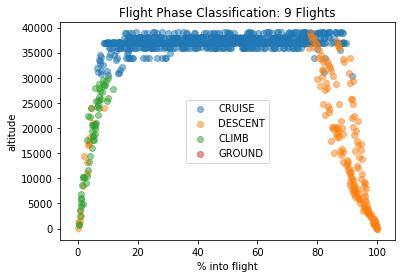

In [11]:
for val in classes:
    plt.scatter(X_test_all[X_test_all["predicted"] == val]["%_into_flight"], X_test_all[X_test_all["predicted"] == val]["altitude"], alpha = 0.5)
plt.legend(classes, loc = "center")
plt.xlabel("% into flight")
plt.ylabel("altitude")
plt.title("Flight Phase Classification: {} Flights".format(len(X_test_all.drop_duplicates(["msn","flight"]))))